## Load data

In [1]:
import sys
 
sys.path.insert(0, "../")

In [2]:
from dataAnalysis.data.Filter import Filter
import pandas as pd
from dataAnalysis.Constants import *
from dataAnalysis.DataAnalysis import DataAnalysis

FEATURES.extend(['Noise0', 'Noise1', 'Noise2', 'Noise3', 'Noise4', 'Noise5', 'Noise6', 'Noise7', 'Noise8', 'Noise9'])
data = pd.read_csv(r"../extdata/noisy_sbc_10.csv", header=0)
data_analysis = DataAnalysis(data, mimic_data = None)

/home/dwalke/git/sbc/machine_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/machine_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/machine_learning/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [3]:
y_train = data_analysis.get_y_train()
X_train = data_analysis.get_X_train()

y_test = data_analysis.get_y_test()
X_test = data_analysis.get_X_test()

y_gw_test = data_analysis.get_y_gw()
X_gw_test = data_analysis.get_X_gw()

## Metrics definition

In [4]:
from dataAnalysis.Metrics import Evaluation

evaluation = Evaluation(y_test, y_gw_test, X_test, X_gw_test)

## Logistic regression

11.402012348175049
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.044771  0.776245  0.441299   0.008708  0.835020  0.009420
1  Greifswald  0.022496  0.593674  0.374282   0.003772  0.755294  0.004283


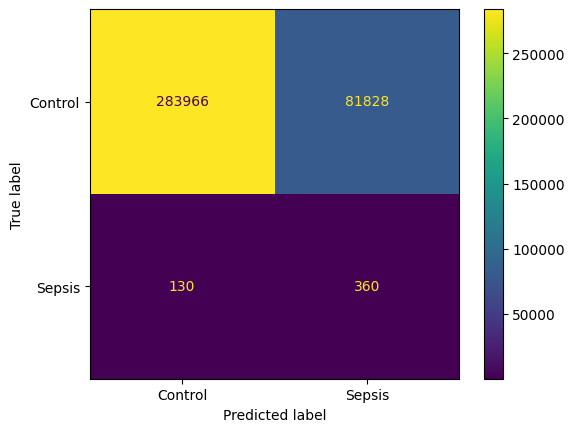

In [5]:
from sklearn.linear_model import LogisticRegression
import time
start = time.time()
logistic_regression = LogisticRegression(random_state=0, solver="liblinear", class_weight="balanced")
logistic_regression.fit(X_train, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(logistic_regression))
evaluation.plot_confusion_matrix(logistic_regression)

## Decision Tree

5.484031677246094
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.043468  0.741567  0.429719   0.008006  0.837761  0.008039
1  Greifswald  0.029989  0.675991  0.405646   0.004796  0.771376  0.002990


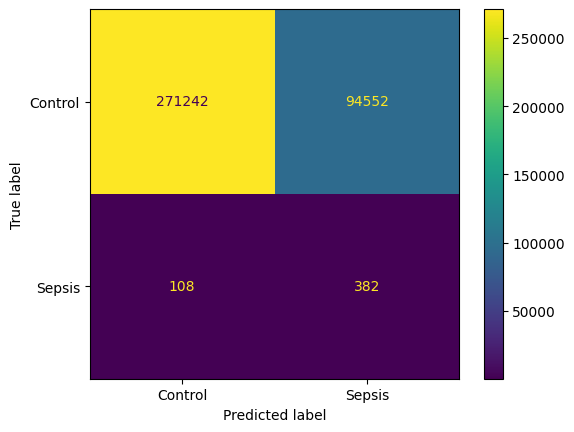

In [6]:
from sklearn.tree import DecisionTreeClassifier
start = time.time()
decision_tree = DecisionTreeClassifier(random_state=42, max_features=6, min_samples_leaf=0.005,
                       min_samples_split=0.03, class_weight="balanced")
decision_tree.fit(X_train, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(decision_tree))
evaluation.plot_confusion_matrix(decision_tree)

## Random Forest

59.45935368537903
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.062875  0.903075  0.482741   0.016456  0.864248  0.015001
1  Greifswald  0.037012  0.860634  0.466459   0.007865  0.815476  0.005226
[0.10235847 0.01296373 0.04751204 0.49737867 0.05767832 0.03844013
 0.1221218  0.01320987 0.01063471 0.01284211 0.01145891 0.01083747
 0.01237419 0.0130173  0.01342602 0.01071168 0.01303458]


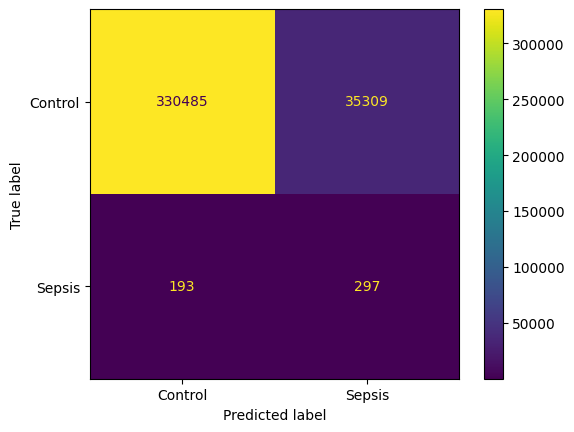

In [7]:
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
random_forest = RandomForestClassifier(class_weight={0: 0.0025, 1: 1}, max_leaf_nodes=79,
                           min_samples_leaf=0.0001,
                           min_samples_split=0.0055,
                           n_estimators=500, random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(random_forest))
evaluation.plot_confusion_matrix(random_forest)
print(random_forest.feature_importances_)

## XG Boost

1.6370506286621094
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.073293  0.981730  0.515193    0.03961  0.862043  0.016278
1  Greifswald  0.037455  0.963399  0.497687    0.01402  0.804082  0.005984


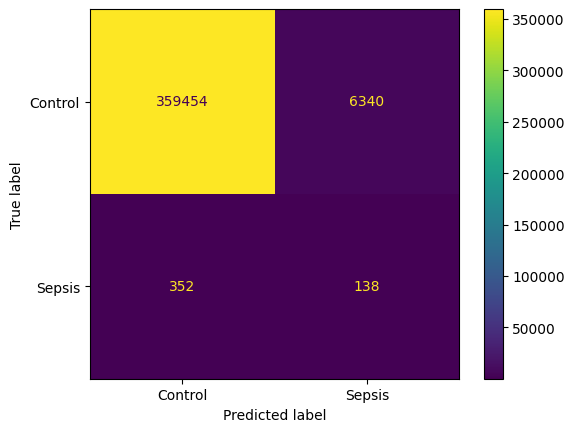

In [8]:
from xgboost import XGBClassifier
import time

start = time.time()
xgb_classifier = XGBClassifier(tree_method='gpu_hist', 
                           scale_pos_weight = 70,
                           n_estimators=1000,
                           max_depth=2,
                           eta=0.1,
                           min_child_weight = 7,
                           max_delta_step= 7,
                           sampling_method= "uniform")
xgb_classifier.fit(X_train, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(xgb_classifier))
evaluation.plot_confusion_matrix(xgb_classifier)

## RUS Boost

/home/dwalke/miniconda3/lib/python3.11/site-packages/imblearn/ensemble/_weight_boosting.py:271: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


198.74555683135986
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.056849  0.868651  0.471426   0.013209  0.860256  0.014767
1  Greifswald  0.036896  0.814679  0.452376   0.006948  0.816899  0.005306


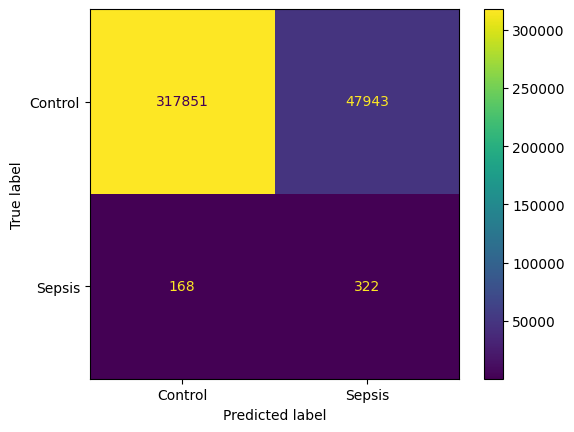

In [9]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
start = time.time()
rus_boost = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=79, min_samples_leaf= 5, min_samples_split = 10),
                   learning_rate=0.90369, n_estimators=495,
                   random_state=1714400672, sampling_strategy=35/65)
rus_boost.fit(X_train, y_train)
print(time.time() -start)
print(evaluation.get_df_metrics(rus_boost))
evaluation.plot_confusion_matrix(rus_boost)